In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import ReLU
from torch.nn import LeakyReLU
from torch.nn import Sigmoid
from torch.nn import Tanh
from torch.nn import ELU
from torch.nn import Conv2d
from torch.nn import AvgPool2d
from torch.nn import MaxPool2d
from torch import flatten
import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#### Prepare for Dataset

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


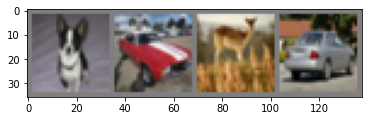

  dog   car  deer   car


In [11]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Choose a Device

In [12]:
print(torch.backends.cudnn.enabled)

True


In [13]:
torch.cuda.is_available()

False

In [14]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


### Try different activation function

In [ ]:
f_list = [ReLU(), LeakyReLU(), Sigmoid(), Tanh(), ELU()]

for f in f_list: 
    print(f)
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            ###### Fill the blank here ######

            #block one
            self.c_1 = Conv2d(3, 10, 3, stride=1, padding=1)
            self.r_1 = f
            self.avg_1 = AvgPool2d(2)

            #block two
            self.c_2 = Conv2d(10, 20, 3, stride=1, padding=1)
            self.r_2 = f
            self.avg_2 = AvgPool2d(2)

            self.l_1 = nn.Linear(1280, 100)
            self.r_3 = f
            self.l_2 = nn.Linear(100, 10)

        def forward(self, x):
            ###### Fill the blank here ######

            #print(x.shape)
            x = self.c_1(x)
            #print(x.shape)
            x = self.r_1(x)
            #print(x.shape)
            x = self.avg_1(x)
            #print(x.shape)

            x = self.c_2(x)
            #print(x.shape)
            x = self.r_2(x)
            #print(x.shape)
            x = self.avg_2(x)
            #print(x.shape)

            x = flatten(x, start_dim=1)
            #print(x.shape)

            x = self.l_1(x)
            #print(x.shape)
            x = self.r_3(x)
            #print(x.shape)
            x = self.l_2(x)
            #print(x.shape)


            return x

    net = Net()     # Create the network instance.
    net.to(device)  # Move the network parameters to the specified device.

    # We use cross-entropy as loss function.
    loss_func = nn.CrossEntropyLoss()

    # SGD
    opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 


    # Training procedure
    st = time.time()
    avg_losses = []   # Avg. losses.
    epochs = 10       # Total epochs.
    print_freq = 5000  # Print frequency.

    for epoch in range(epochs):  # Loop over the dataset multiple times.
        running_loss = 0.0       # Initialize running loss.
        for i, data in enumerate(trainloader, 0):
            # Get the inputs.
            inputs, labels = data
    #         print(inputs)
    #         print(labels)
            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.
            opt.zero_grad()

            # Forward step.
            outputs = net(inputs)
            loss = loss_func(outputs, labels)

            # Backward step.
            loss.backward()

            # Optimization step (update the parameters).
            opt.step()

            # Print statistics.
            running_loss += loss.item()
            if i % print_freq == print_freq - 1: # Print every several mini-batches.
                avg_loss = running_loss / print_freq
                print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                    epoch, i, avg_loss))
                avg_losses.append(avg_loss)
                running_loss = 0.0

    print('Finished Training.')
    et = time.time()
    print((et-st)/60)

    plt.plot(avg_losses)
    plt.xlabel('mini-batch index / {}'.format(print_freq))
    plt.ylabel('avg. mini-batch loss')
    plt.show()


    # Check several images.
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))


    # Get test accuracy.
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


    # Get test accuracy for each class.
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

ReLU()
[epoch: 0, i:  4999] avg mini-batch loss: 1.865
[epoch: 0, i:  9999] avg mini-batch loss: 1.542
[epoch: 1, i:  4999] avg mini-batch loss: 1.357
[epoch: 1, i:  9999] avg mini-batch loss: 1.299
[epoch: 2, i:  4999] avg mini-batch loss: 1.188
[epoch: 2, i:  9999] avg mini-batch loss: 1.161


### Try different optimizer

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ###### Fill the blank here ######

        #block one
        self.c_1 = Conv2d(3, 10, 3, stride=1, padding=1)
        self.r_1 = ReLU()
        self.avg_1 = AvgPool2d(2)

        #block two
        self.c_2 = Conv2d(10, 20, 3, stride=1, padding=1)
        self.r_2 = ReLU()
        self.avg_2 = AvgPool2d(2)

        self.l_1 = nn.Linear(1280, 100)
        self.r_3 = ReLU()
        self.l_2 = nn.Linear(100, 10)

    def forward(self, x):
        ###### Fill the blank here ######

        #print(x.shape)
        x = self.c_1(x)
        #print(x.shape)
        x = self.r_1(x)
        #print(x.shape)
        x = self.avg_1(x)
        #print(x.shape)

        x = self.c_2(x)
        #print(x.shape)
        x = self.r_2(x)
        #print(x.shape)
        x = self.avg_2(x)
        #print(x.shape)

        x = flatten(x, start_dim=1)
        #print(x.shape)

        x = self.l_1(x)
        #print(x.shape)
        x = self.r_3(x)
        #print(x.shape)
        x = self.l_2(x)
        #print(x.shape)


        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

opt_list = [optim.SGD(net.parameters(), lr=0.001, momentum=0.9), 
            optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False), 
            optim.Adagrad(net.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10), 
            optim.Adadelta(net.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0), 
            optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False),
            optim.Adamax(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0),
            optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)]

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()

for opt in opt_list:
    # SGD
    opt = opt
    print(opt)
    # Training procedure
    st = time.time()
    avg_losses = []   # Avg. losses.
    epochs = 10       # Total epochs.
    print_freq = 5000  # Print frequency.

    for epoch in range(epochs):  # Loop over the dataset multiple times.
        running_loss = 0.0       # Initialize running loss.
        for i, data in enumerate(trainloader, 0):
            # Get the inputs.
            inputs, labels = data
    #         print(inputs)
    #         print(labels)
            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.
            opt.zero_grad()

            # Forward step.
            outputs = net(inputs)
            loss = loss_func(outputs, labels)

            # Backward step.
            loss.backward()

            # Optimization step (update the parameters).
            opt.step()

            # Print statistics.
            running_loss += loss.item()
            if i % print_freq == print_freq - 1: # Print every several mini-batches.
                avg_loss = running_loss / print_freq
                print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                    epoch, i, avg_loss))
                avg_losses.append(avg_loss)
                running_loss = 0.0

    print('Finished Training.')
    et = time.time()
    print((et-st)/60)

    plt.plot(avg_losses)
    plt.xlabel('mini-batch index / {}'.format(print_freq))
    plt.ylabel('avg. mini-batch loss')
    plt.show()


    # Check several images.
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))


    # Get test accuracy.
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


    # Get test accuracy for each class.
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

### Try different pooling

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ###### Fill the blank here ######

        #block one
        self.c_1 = Conv2d(3, 10, 3, stride=1, padding=1)
        self.r_1 = ReLU()
        self.max_1 = MaxPool2d(2)

        #block two
        self.c_2 = Conv2d(10, 20, 3, stride=1, padding=1)
        self.r_2 = ReLU()
        self.max_2 = MaxPool2d(2)

        self.l_1 = nn.Linear(1280, 100)
        self.r_3 = ReLU()
        self.l_2 = nn.Linear(100, 10)

    def forward(self, x):
        ###### Fill the blank here ######

        #print(x.shape)
        x = self.c_1(x)
        #print(x.shape)
        x = self.r_1(x)
        #print(x.shape)
        x = self.max_1(x)
        #print(x.shape)

        x = self.c_2(x)
        #print(x.shape)
        x = self.r_2(x)
        #print(x.shape)
        x = self.max_2(x)
        #print(x.shape)

        x = flatten(x, start_dim=1)
        #print(x.shape)

        x = self.l_1(x)
        #print(x.shape)
        x = self.r_3(x)
        #print(x.shape)
        x = self.l_2(x)
        #print(x.shape)


        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()

# SGD
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 


# Training procedure
st = time.time()
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 5000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
#         print(inputs)
#         print(labels)
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')
et = time.time()
print((et-st)/60)

plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()


# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

### Add more layers:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ###### Fill the blank here ######

        #block one
        self.c_1 = Conv2d(3, 10, 3, stride=1, padding=1)
        self.r_1 = ReLU()
        self.avg_1 = AvgPool2d(2)

        #block two
        self.c_2 = Conv2d(10, 20, 3, stride=1, padding=1)
        self.r_2 = ReLU()
        self.avg_2 = AvgPool2d(2)

        #Block three
        self.c_3 = Conv2d(20, 30, 3, stride=1, padding=1)
        self.r_3 = ReLU()
        self.avg_3 = AvgPool2d(2)
        
        #Block four
        self.c_4 = Conv2d(30, 40, 3, stride=1, padding=1)
        self.r_4 = ReLU()
        self.avg_4 = AvgPool2d(2)
        
        
        self.l_1 = nn.Linear(160, 100)
        self.r_3 = ReLU()
        self.l_2 = nn.Linear(100, 10)

    def forward(self, x):
        ###### Fill the blank here ######

        #print(x.shape)
        x = self.c_1(x)
        #print(x.shape)
        x = self.r_1(x)
        #print(x.shape)
        x = self.avg_1(x)
        #print(x.shape)

        x = self.c_2(x)
        #print(x.shape)
        x = self.r_2(x)
        #print(x.shape)
        x = self.avg_2(x)
        #print(x.shape)

        x = self.c_3(x)
        #print(x.shape)
        x = self.r_3(x)
        #print(x.shape)
        x = self.avg_3(x)
        
        x = self.c_4(x)
        #print(x.shape)
        x = self.r_4(x)
        #print(x.shape)
        x = self.avg_4(x)
        
        x = flatten(x, start_dim=1)
        #print(x.shape)

        x = self.l_1(x)
        #print(x.shape)
        x = self.r_3(x)
        #print(x.shape)
        x = self.l_2(x)
        #print(x.shape)

        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()

# SGD
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 


# Training procedure
st = time.time()
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 5000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
#         print(inputs)
#         print(labels)
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')
et = time.time()
print((et-st)/60)

plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()


# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))